### In this notebook, we will analyze the patron compositions during the period of 01/01/2018 to 06/10/2019. Patron visit frequencies are binned into 30 buckets with incrementals of 10 visits (1-10, 11-20, ..., 291-300, 300+).

### Preliminary anaysis is performed to answer the following questions:
    1. At each bin of frequency, how many patrons are visiting the casino?
    2. Within each bin of frequency, what are the compositions of different tiers?
    3. What are the percentages of total casino wins from players within each bin of visiting frequency?

### Data preparation: Raw data is exported into ".txt" file from Access ODBC database. 
### Query used to get the data is shown in the following:

### player_010118_061009.txt: 

        SELECT dbo_CDS_StatDay.*
        FROM dbo_CDS_StatDay
        WHERE (((dbo_CDS_StatDay.GamingDate)>='01/01/2018')) AND (((dbo_CDS_StatDay.GamingDate)<='06/10/2019'));

### dbo_PlayerRank.txt:
    
        SELECT dbo_PlayerRank.*
        FROM dbo_PlayerRank;


In [105]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [169]:
# Read in day-stat data from 01/01/2018 to 06/10/2019:

logs = pd.read_csv('CDS_StatDay_010118_061019.txt',sep = ',')
players = pd.read_csv('dbo_PlayerRank.txt', sep = ',')

In [171]:
# Top five rows of players table:

players.head()

,PlayerID,RankID,SystemRankID,ManualRankID,LastSysCalcDate,UpdateDatetime,ExcludePlayerInTierJob,RowVersion
0,100000,0,0,NaN,1/1/1900 0:00:00,1/1/1900 0:00:00,0,NaN
1,100001,0,0,NaN,1/1/1900 0:00:00,2/7/2018 20:40:45,0,NaN
2,100002,0,0,NaN,7/2/2013 17:43:00,5/10/2016 19:33:49,0,NaN
3,100003,0,0,NaN,7/2/2013 17:43:00,7/2/2013 17:42:53,0,NaN
4,100004,0,0,NaN,4/23/2014 10:11:00,5/10/2016 19:30:10,0,NaN


In [172]:
# top 5 rows of players daily activities table:

logs.head()

,PlayerID,StatType,GamingDate,TimePlayed,MoneyPlay,CashIn,FrontIn,ChipsIn,CreditIn,CashOut,...,TWin,PtsEarned,PromoPtsEarned,DollarsEarned,PromoDollarsEarned,CompEarned,RawAverageBetTimesTime,PromoPlay,IDType,Meta_ID
0,100033,SLOT,2018-01-01,3992,$0.00,$580.00,$0.00,$0.00,$0.00,$478.20,...,$57.21,580,0,$1.16,$0.00,$0.00,$0.00,$5.00,P,100033
1,100038,SLOT,2018-01-01,9019,$0.00,$6165.00,$0.00,$0.00,$0.00,$3725.00,...,$635.66,6165,0,$12.33,$0.00,$0.00,$0.00,$420.00,P,100038
2,100084,SLOT,2018-01-01,7940,$0.00,$1448.90,$0.00,$0.00,$0.00,$1214.75,...,$47.15,725,0,$1.45,$0.00,$0.00,$0.00,$20.00,P,100084
3,100101,SLOT,2018-01-01,4543,$0.00,$142.06,$0.00,$0.00,$0.00,$195.44,...,$15.85,142,0,$0.28,$0.00,$0.00,$0.00,$10.00,P,100101
4,100107,SLOT,2018-01-01,7149,$0.00,$217.48,$0.00,$0.00,$0.00,$210.45,...,$30.29,217,0,$0.43,$0.00,$0.00,$0.00,$5.00,P,100107


In [173]:
logs.head()

,PlayerID,StatType,GamingDate,TimePlayed,MoneyPlay,CashIn,FrontIn,ChipsIn,CreditIn,CashOut,...,TWin,PtsEarned,PromoPtsEarned,DollarsEarned,PromoDollarsEarned,CompEarned,RawAverageBetTimesTime,PromoPlay,IDType,Meta_ID
0,100033,SLOT,2018-01-01,3992,$0.00,$580.00,$0.00,$0.00,$0.00,$478.20,...,$57.21,580,0,$1.16,$0.00,$0.00,$0.00,$5.00,P,100033
1,100038,SLOT,2018-01-01,9019,$0.00,$6165.00,$0.00,$0.00,$0.00,$3725.00,...,$635.66,6165,0,$12.33,$0.00,$0.00,$0.00,$420.00,P,100038
2,100084,SLOT,2018-01-01,7940,$0.00,$1448.90,$0.00,$0.00,$0.00,$1214.75,...,$47.15,725,0,$1.45,$0.00,$0.00,$0.00,$20.00,P,100084
3,100101,SLOT,2018-01-01,4543,$0.00,$142.06,$0.00,$0.00,$0.00,$195.44,...,$15.85,142,0,$0.28,$0.00,$0.00,$0.00,$10.00,P,100101
4,100107,SLOT,2018-01-01,7149,$0.00,$217.48,$0.00,$0.00,$0.00,$210.45,...,$30.29,217,0,$0.43,$0.00,$0.00,$0.00,$5.00,P,100107


In [174]:
# Calculate the net win/loss for each player at each play:

for columns in ['CashIn', 'FrontIn', 'ChipsIn', 'CreditIn', 'CashOut', 'CashOut', 'JackPot', 'TWin']:
    logs[columns] = logs[columns].replace('[\$,]', '', regex=True).astype(float)
    
logs['NetWinLoss'] = -(logs['CashIn'] + logs['ChipsIn'] + logs['CreditIn'] - logs['JackPot'] - logs['CashOut'])


In [175]:
# Create summary table of player visit numbers and win/loss for each visit:

player_daily_activities = logs.loc[:,['PlayerID', 'GamingDate', 'CashIn', 'FrontIn', \
                                   'ChipsIn', 'CreditIn', 'CashOut', 'CashOut', \
                                   'JackPot', 'TWin', 'NetWinLoss']]

player_loss = player_daily_activities.groupby(by = ['PlayerID'])['NetWinLoss'].sum().reset_index()
player_visits = player_daily_activities.groupby(by = 'PlayerID')['GamingDate'].nunique().reset_index()\
                                       .rename(columns = {'GamingDate': 'NumVisits'})

player_visits_loss = player_loss.merge(player_visits, how = 'left', on = 'PlayerID')
player_visits_loss['AvgLoss'] = player_visits_loss['NetWinLoss']/player_visits_loss['NumVisits']

player_visits_summary = player_visits_loss.merge(players, on = 'PlayerID')\
                                          .loc[:,['PlayerID', 'NetWinLoss', 'NumVisits', 'AvgLoss', 'RankID']]

In [176]:
# For each player, find frequency bin the player belongs:

def find_bin(x):
    if round(x/10) < 30:
        bins = str((10*int(x/10))+1) + '-' + str(10*(int(x/10)+1))
    else: bins = '300+'
    
    return bins  

player_visits_summary['FreqInterval'] = player_visits_summary['NumVisits']\
                                        .apply(lambda x: find_bin(x))

In [177]:
# Top 5 row of player visit summary table:

player_visits_summary.head()

,PlayerID,NetWinLoss,NumVisits,AvgLoss,RankID,FreqInterval
0,100001,-89.75,1,-89.750000,0,1-10
1,100005,-77.15,2,-38.575000,0,1-10
2,100006,-15.03,6,-2.505000,0,1-10
3,100011,-2910.32,28,-103.940000,2,21-30
4,100015,-1668.94,51,-32.724314,0,51-60


In [178]:
# Find number of players within each bin of visit frequencies:

headcounts = player_visits_summary.groupby(by = 'FreqInterval')['PlayerID']\
                                  .nunique().reset_index()\
                                  .rename(columns = {'PlayerID': 'Headcounts'})

headcounts['count_start'] = headcounts['FreqInterval'].apply(lambda x: int(x.strip('+').split('-')[0]))
headcounts = headcounts.sort_values(by = 'count_start').reset_index(drop = True)\
                       .loc[:,['FreqInterval','Headcounts']]

In [179]:
# For each frequency interval, identify the composition of player tiers:


rank_visit_freq = player_visits_summary.groupby(by = ['FreqInterval', 'RankID'])['PlayerID']\
                                       .count().reset_index()\
                                       .rename(columns = {'PlayerID':'Counts'})

rank_0 = []
rank_1 = []
rank_2 = []
rank_3 = []
rank_4 = []
for interval in headcounts['FreqInterval']:
    df = rank_visit_freq[rank_visit_freq['FreqInterval'] == interval]
    rank_0.append(list(df[df['RankID'] == 0]['Counts'])[0] if len(list(df[df['RankID'] == 0]['Counts'])) != 0 else 0)
    rank_1.append(list(df[df['RankID'] == 1]['Counts'])[0] if len(list(df[df['RankID'] == 1]['Counts'])) != 0 else 0)
    rank_2.append(list(df[df['RankID'] == 2]['Counts'])[0] if len(list(df[df['RankID'] == 2]['Counts'])) != 0 else 0)
    rank_3.append(list(df[df['RankID'] == 3]['Counts'])[0] if len(list(df[df['RankID'] == 3]['Counts'])) != 0 else 0)
    rank_4.append(list(df[df['RankID'] == 4]['Counts'])[0] if len(list(df[df['RankID'] == 4]['Counts'])) != 0 else 0)
    
headcounts['Rank_0'] = rank_0
headcounts['Rank_1'] = rank_1
headcounts['Rank_2'] = rank_2
headcounts['Rank_3'] = rank_3
headcounts['Rank_4'] = rank_4

headcounts_rank = headcounts.rename(columns = {'Rank_0': 'Marquee Rewards',\
                                          'Rank_1': 'Celebrity',\
                                          'Rank_2': 'Producer',\
                                          'Rank_3': 'Executive Producer',\
                                          'Rank_4': 'Icon'})

headcounts_rank_pct = headcounts_rank.copy()
for rank in ['Marquee Rewards', 'Celebrity', 'Producer', 'Executive Producer', 'Icon']:
    headcounts_rank_pct[rank] = headcounts_rank_pct[rank]/headcounts_rank_pct['Headcounts']

In [180]:
# Calculate percentages of total casino wins for each bin of visit frequencies (in 10 increments):

win_composition = {}
for i in range(30):
    win_composition[str(10*i+1) + '-' + str(10*(i+1))] = [(player_visits_summary[player_visits_summary['NumVisits'] <= 10*(i+1)]['NetWinLoss'].sum()\
                                                      - player_visits_summary[player_visits_summary['NumVisits'] <= 10*i]['NetWinLoss'].sum())\
                                                      / player_visits_summary['NetWinLoss'].sum()]

win_composition['300+'] = [player_visits_summary[player_visits_loss['NumVisits'] > 300]['NetWinLoss'].sum()\
                          /player_visits_loss['NetWinLoss'].sum()]

### 1. At each bin of frequency, how many patrons are visiting the casino?
    The histogram below shows the number of patrons who visited casino within each bin of frequency:

Text(0, 0.5, 'Frequencies')

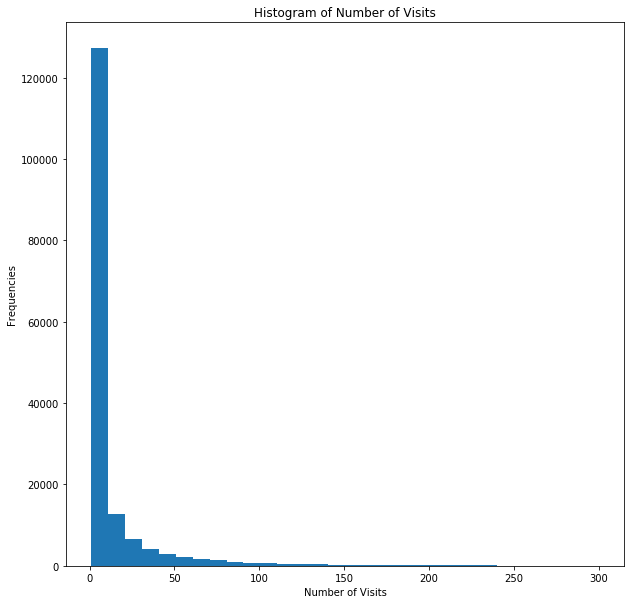

In [181]:
# Plot histogram of number of visits amiong players:

%matplotlib inline

histogram = player_visits_summary[player_visits_summary['NumVisits']<=300]['NumVisits']\
          .plot(kind = 'hist', bins = 30, figsize = (10,10), title = 'Histogram of Number of Visits')
histogram.set_xlabel('Number of Visits')
histogram.set_ylabel('Frequencies')

### 2. Within each bin of frequency, what are the compositions of different tiers?

        The two stacked bar of ranking plot will show the compostition of tiers within each bin of visiting frequency.
        We can see that most number of people who visitsd vasino druin time period of 01/01/2018 to 06/10/2019 visited 
        casino between 1 to 10 times.We can also see that within each bin of visiting, the percentage of each tier varies.

Text(0, 0, '1-10')

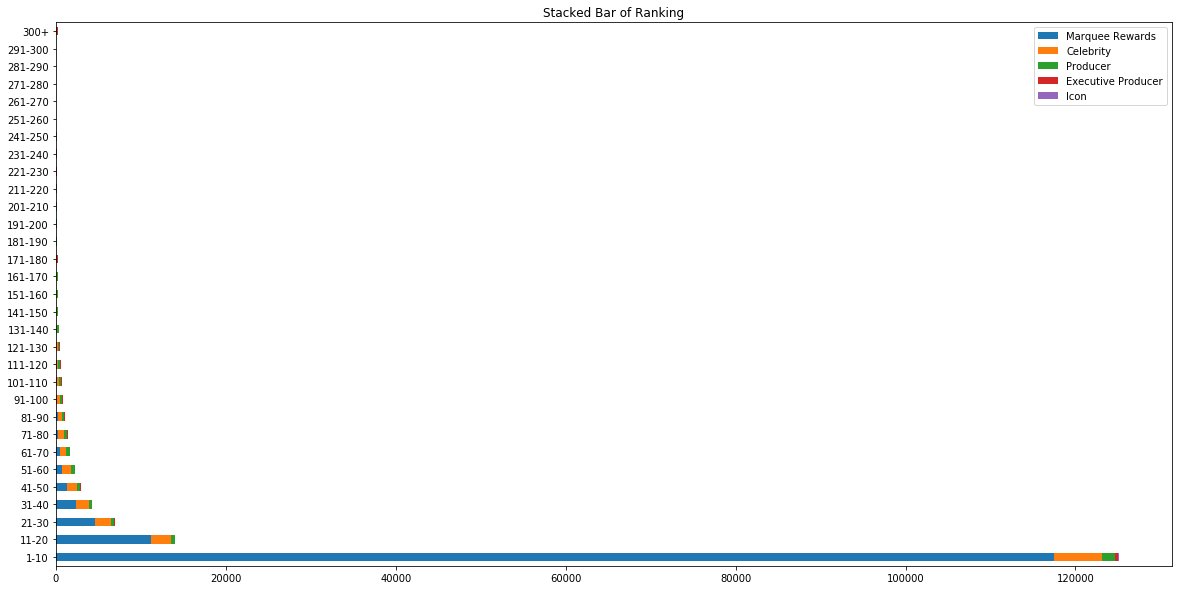

In [182]:
# Plot horizontal stacked bar chart:

headcounts_plot_data = headcounts_rank.loc[:,['Marquee Rewards', 'Celebrity', 'Producer', 'Executive Producer', 'Icon']]
ax = headcounts_plot_data.plot(kind = 'barh', \
                          stacked = True, \
                          figsize = (20,10), \
                          title = 'Stacked Bar of Ranking')
ax.set_yticklabels(headcounts_rank['FreqInterval'])[0]

Text(0, 0, '1-10')

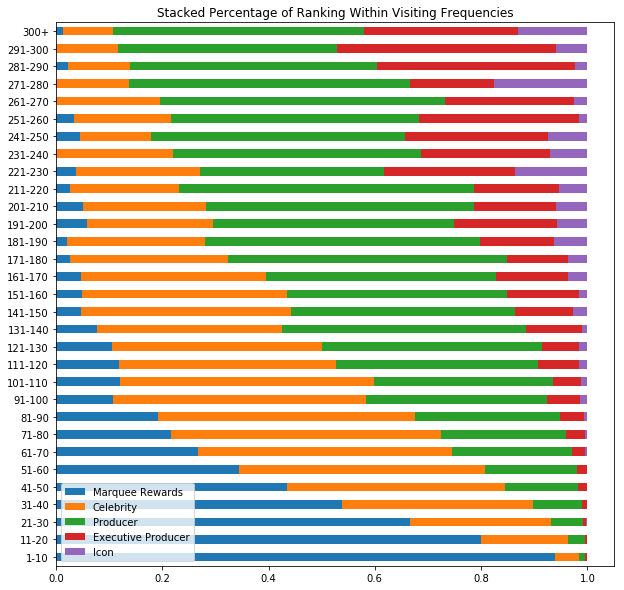

In [183]:
# Plot stacked percentage composition bar plot:

p = headcounts_rank_pct.loc[:,['Marquee Rewards', 'Celebrity', 'Producer', 'Executive Producer', 'Icon']]
stacked_rank_pct = p.plot(kind = 'barh', stacked = True, figsize = (10,10), \
                          title = 'Stacked Percentage of Ranking Within Visiting Frequencies')
stacked_rank_pct.set_yticklabels(headcounts_rank['FreqInterval'])[0]

### 3. What are the percentages of total casino wins from players within each bin of visiting frequency?

    The following pie chart visualizes percentage of total casino wins from players within each bin of visiting frequency.

Text(0, 0.5, 'Winning Fraction')

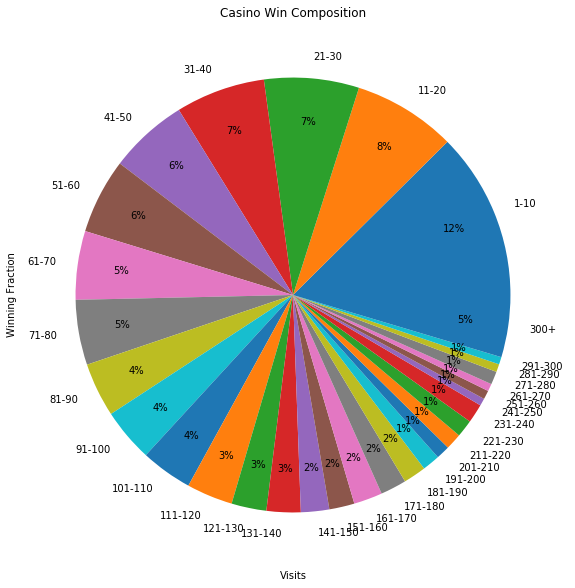

In [184]:
# Plotting a pie chart to visualize the percentage of players losses of each bin of visit frequency:

df_win_pctg = pd.DataFrame.from_dict(win_composition, orient = 'index', columns = ['casino_win_percentage'])
casino_win_comp = df_win_pctg['casino_win_percentage'].plot(kind = 'pie', figsize = (10,10),\
                                                       title = 'Casino Win Composition',\
                                                       autopct = '%1.0f%%',\
                                                       pctdistance = 0.8, labeldistance = 1.1)
casino_win_comp.set_xlabel('Visits')
casino_win_comp.set_ylabel('Winning Fraction')

### Data uesd to generate plots:

In [185]:
# Summary of player visits (top 10 rows):

player_visits_summary.head(10)

,PlayerID,NetWinLoss,NumVisits,AvgLoss,RankID,FreqInterval
0,100001,-89.75,1,-89.750000,0,1-10
1,100005,-77.15,2,-38.575000,0,1-10
2,100006,-15.03,6,-2.505000,0,1-10
3,100011,-2910.32,28,-103.940000,2,21-30
4,100015,-1668.94,51,-32.724314,0,51-60
5,100019,-7.77,2,-3.885000,0,1-10
6,100021,-582.58,3,-194.193333,0,1-10
7,100023,-2700.57,63,-42.866190,0,61-70
8,100024,-15.42,34,-0.453529,0,31-40
9,100025,-3916.49,54,-72.527593,1,51-60


In [186]:
# Number of players and rank composition within each bin of frequency:

headcounts_rank

,FreqInterval,Headcounts,Marquee Rewards,Celebrity,Producer,Executive Producer,Icon
0,1-10,125102,117468,5700,1489,363,82
1,11-20,14048,11230,2308,443,52,15
2,21-30,6922,4617,1836,416,39,14
3,31-40,4298,2317,1540,397,37,7
4,41-50,2932,1274,1202,407,47,2
5,51-60,2235,770,1036,384,43,2
6,61-70,1656,444,791,372,43,6
7,71-80,1366,296,695,320,49,6
8,81-90,1023,196,496,279,45,7
9,91-100,812,87,387,277,50,11


In [187]:
# Casino win percentage from players within each bin of visiting frequency:

df_win_pctg

,casino_win_percentage
1-10,0.124363
11-20,0.076583
21-30,0.070473
31-40,0.066570
41-50,0.058664
51-60,0.055870
61-70,0.051023
71-80,0.048375
81-90,0.040240
91-100,0.039573
